In [17]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import dump, load
from sklearn.metrics import roc_auc_score

## Load Model and Data

In [62]:
#LOAD IMPUTED DATASETS
#make directory 
dataDir = 'AnalysisData'
dataSubDir = 'ImputedData'

path = os.path.join(dataDir, dataSubDir, 'SimpleImputedFeatures_01.csv')
test_x_imp01_pd = pd.read_csv (path, index_col = 'HHX')
test_x_imp01 = test_x_imp01_pd.to_numpy()
print(test_x_imp01.shape)

path = os.path.join(dataDir, dataSubDir, 'SimpleImputedFeatures_02.csv')
test_x_imp02_pd = pd.read_csv (path, index_col = 'HHX')
test_x_imp02 = test_x_imp02_pd.to_numpy()
print(test_x_imp02.shape)

path = os.path.join(dataDir, dataSubDir, 'SimpleImputedFeatures_03.csv')
test_x_imp03_pd = pd.read_csv (path, index_col = 'HHX')
test_x_imp03 = test_x_imp03_pd.to_numpy()
print(test_x_imp03.shape)

path = os.path.join(dataDir, dataSubDir, 'SimpleImputedFeatures_04.csv')
test_x_imp04_pd = pd.read_csv (path, index_col = 'HHX')
test_x_imp04 = test_x_imp04_pd.to_numpy()
print(test_x_imp04.shape)

path = os.path.join(dataDir, dataSubDir, 'SimpleImputedFeatures_05.csv')
test_x_imp05_pd = pd.read_csv (path, index_col = 'HHX')
test_x_imp05 = test_x_imp05_pd.to_numpy()
print(test_x_imp05.shape)

test_datasets = [test_x_imp01, test_x_imp02, test_x_imp03, test_x_imp04, test_x_imp05]
test_datasets_pd = [test_x_imp01_pd, test_x_imp02_pd, test_x_imp03_pd, test_x_imp04_pd, test_x_imp05_pd]

(5556, 5290)
(5556, 5290)
(5556, 5290)
(5556, 5290)
(5556, 5290)


In [94]:
#LOAD ORIGINAL DATASETS
dataDir = 'AnalysisData'
dataSubDir = 'CleanDataFinal'

#LOAD TESTING DATA
#features
path = os.path.join(dataDir, dataSubDir, 'testFeaturesFinal.csv')
test_x_pd = pd.read_csv (path, index_col = 'HHX')
test_x = test_x_pd.to_numpy()
print(test_x.shape)

#target
path = os.path.join(dataDir, dataSubDir, 'testTargetFinal.csv')
test_y_pd = pd.read_csv (path, index_col = 'HHX')
test_y = test_y_pd.to_numpy().flatten()
print(test_y.shape)

test_datasets.append(test_x)
test_datasets_pd.append(test_x_pd)

(5556, 5290)
(5556,)


In [67]:
#LOAD RANKING LISTS USED TO TRAIN REDUCED FEATURE MODELS
dataDir = 'AnalysisData'
dataSubDir = 'FeatureSelection'
fpath = 'FeatureSelection_SelectedFeatures.csv'
path = os.path.join(dataDir, dataSubDir, fpath)
featureRankings = pd.read_csv (path, index_col=0)

In [50]:
#LOAD TRAINED MODELS
dataDir='AnalysisData'
dataSubDir='Models'

file_name='RFC_FullData.joblib'
RFC_path = os.path.join(dataDir, dataSubDir, file_name)
RFC_full = load(RFC_path) 

file_name='RFC_noGAD.joblib'
RFC_path = os.path.join(dataDir, dataSubDir, file_name)
RFC_noGAD = load(RFC_path) 

file_name='RFC_415_features.joblib'
RFC_path = os.path.join(dataDir, dataSubDir, file_name)
RFC_01 = load(RFC_path)

file_name='RFC_1640_features.joblib'
RFC_path = os.path.join(dataDir, dataSubDir, file_name)
RFC_50 = load(RFC_path)

file_name='RFC_2890_features.joblib'
RFC_path = os.path.join(dataDir, dataSubDir, file_name)
RFC_100 = load(RFC_path)

In [59]:
#FUNCTION FOR TESTING MODELS
def test_model (test_datasets_pd, test_y, model):
    '''Tests model using ROC AUC ovr weighted metric
    test_datasets: list of df representing testing sets
    test_y: array representing correct testing label
    model: trained model
    RETURNS: list of scores'''
    test_scores = []
    for dset in test_datasets_pd:
        roc_auc_test = roc_auc_score(test_y, model.predict_proba(dset), multi_class='ovr', average='weighted')
        test_scores.append(roc_auc_test)
    return (test_scores)

In [70]:
#FUNCTION FOR SELECTING SUBSETS OF FEATURES BASED ON RANKINGS
def select_test_subset (featureRankings, max_rank, test_datasets_pd):
    '''Selects testing subset based on feature rankings
    featureRankings: df containing feature names and rankings
    max_rank: max rank allowed for features
    test_datasets: list of df representing testing sets
    RETURNS: list of arrays containing testing subsets '''
    subsets = []
    for dset in test_datasets_pd:
        cols = featureRankings.FeatureName[featureRankings.Ranking<=max_rank]
        subset = dset.loc[:, cols]
        subset = subset.to_numpy()
        subsets.append(subset)
    return (subsets)

In [95]:
#TEST MODELS ON REAL AND IMPUTED DATA

#list to hold all test scores
scores = []

#model: full dataset
test_list = test_datasets
model = RFC_full
model_scores = test_model(test_list, test_y, model)
scores.append(model_scores)

#model: no GAD
model = RFC_noGAD
#take out GAD features
test_list = []
cols_GAD = test_x_pd.columns[test_x_pd.columns.str.contains('GAD')]
for dset in test_datasets_pd:
    subset = dset.drop(columns=cols_GAD)
    subset = subset.to_numpy()
    test_list.append(subset)

model_scores = test_model(test_list, test_y, model)
scores.append(model_scores)

#model: reduced features
models = [RFC_100, RFC_50, RFC_01]
ranks = [100, 50, 1]
for m, r in zip (models, ranks):
    test_list = select_test_subset(featureRankings, r, test_datasets_pd)
    model_scores = test_model(test_list, test_y, m)
    ≈.append(model_scores)

In [99]:
#MAKE SCORES DF
#make df
cols = []
for i in np.arange(1, 6):
    c = 'IMP_DSET_' + str(i)
    cols.append(c)
cols.append ('ORIGINAL')

idx = ['FULL', 'NO GAD', '1640_FEATURES', '2890_FEATURES', '415_FEATURES']
scores_df = pd.DataFrame(scores, columns=cols, index=idx)
#add basic stats
scores_imp = scores_df.drop(columns=['ORIGINAL'])
scores_df['IMP_MEAN']=scores_imp.mean(axis=1)
scores_df['IMP_STD']=scores_imp.std(axis=1)
#save data
path = 'ImpTest.csv'
scores_df.to_csv(path)

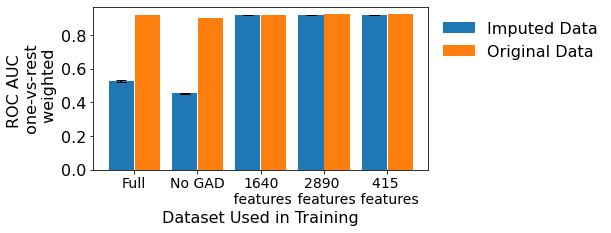

In [113]:
#GRAPH SCORES

plt.figure(figsize=(6,3))

ximp = np.arange(0, 10, 2)
xorig = ximp+0.82
plt.bar(x, scores_df.IMP_MEAN, yerr=scores_df.IMP_STD, capsize=5, label = 'Imputed Data')
plt.bar(xorig, scores_df.ORIGINAL, label = 'Original Data')

idx = ['Full', 'No GAD', '1640\n features', '2890 \n features', '415 \n features']
plt.xticks((x+xorig)/2, idx, fontsize=14)
plt.xlabel ('Dataset Used in Training', fontsize=16)

plt.yticks(fontsize=16)
plt.ylabel('ROC AUC \n one-vs-rest \n weighted', fontsize=16)

plt.legend(bbox_to_anchor=(1, 1), frameon=False, fontsize=16)

datafile = 'ImpTesting.png'
path = os.path.join(datafile)
plt.savefig(path, bbox_inches="tight")
    
plt.show()